# MultiSimilarityLoss

### Import Libraries

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pytorch_metric_learning.losses import MultiSimilarityLoss
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from pytorch_metric_learning.losses import TripletMarginLoss, ContrastiveLoss
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.miners import PairMarginMiner

### Easy cnn encoder for embeddings

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64, embedding_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### Dataset & DataLoader (MNIST)

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(embedding_dim=128).to(device)
loss_fn = MultiSimilarityLoss(alpha=2, beta=50, base=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


### Training with MultiSimilarityLoss

In [4]:
all_embeddings = []
all_labels = []

model.train()
for epoch in range(5):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)
        loss = loss_fn(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
    
    # Embeddings speichern für spätere Visualisierung
    model.eval()
    with torch.no_grad():
        sample_imgs, sample_labels = next(iter(trainloader))
        emb = model(sample_imgs.to(device)).cpu()
        all_embeddings.append(emb)
        all_labels.append(sample_labels)
    model.train()

Epoch 1, Loss: 1.1252
Epoch 2, Loss: 1.0865
Epoch 3, Loss: 1.0187
Epoch 4, Loss: 0.9619
Epoch 5, Loss: 0.9968


### Cosine Similarity Distribution

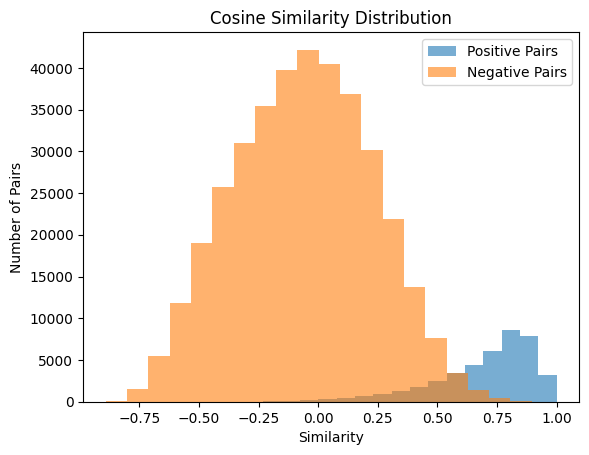

In [5]:
embeds = torch.cat(all_embeddings)
labels = torch.cat(all_labels)
sims = F.cosine_similarity(embeds.unsqueeze(1), embeds.unsqueeze(0), dim=2)
label_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)

positive_sims = sims[label_matrix].flatten().tolist()
negative_sims = sims[~label_matrix].flatten().tolist()

plt.hist(positive_sims, bins=20, alpha=0.6, label="Positive Pairs")
plt.hist(negative_sims, bins=20, alpha=0.6, label="Negative Pairs")
plt.title("Cosine Similarity Distribution")
plt.xlabel("Similarity")
plt.ylabel("Number of Pairs")
plt.legend()
plt.show()


### ROC AUC Score

In [6]:
true_labels = label_matrix.flatten().numpy()
sim_values = sims.flatten().detach().numpy()
auc = roc_auc_score(true_labels, sim_values)
print("ROC AUC Score:", auc)

ROC AUC Score: 0.9775726480353564


### T-SNE Visualization

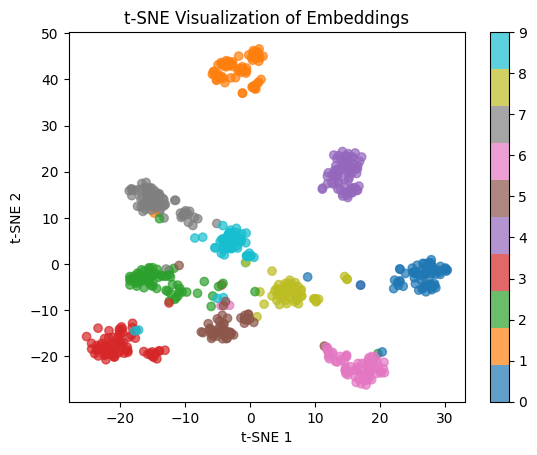

In [7]:
reduced = TSNE(n_components=2, random_state=42).fit_transform(embeds)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

## !! Experiment with Constrastive Loss, Triplet Loss and MultiSimilarityLoss !!

In [30]:
def train_model(loss_fn, loss_name, device, trainloader, embedding_dim=128, epochs=3):
    model = SimpleCNN(embedding_dim=embedding_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    all_embeddings = []
    all_labels = []

    for epoch in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            
            if "Triplet" in loss_name:
                miner = TripletMarginMiner(margin=0.2, type_of_triplets="hard")
                hard_pairs = miner(embeddings, labels)
                loss = loss_fn(embeddings, labels, hard_pairs)
            
            elif "Contrastive" in loss_name:
                miner = PairMarginMiner(pos_margin=0, neg_margin=1)
                hard_pairs = miner(embeddings, labels)
                loss = loss_fn(embeddings, labels, hard_pairs)
            
            else:
                loss = loss_fn(embeddings, labels)



            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"[{loss_name}] Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Save embeddings for evaluation
        model.eval()
        with torch.no_grad():
            sample_imgs, sample_labels = next(iter(trainloader))
            emb = model(sample_imgs.to(device)).cpu()
            all_embeddings.append(emb)
            all_labels.append(sample_labels)

    return torch.cat(all_embeddings), torch.cat(all_labels)


In [31]:
# Loss-Instanzen definieren
ms_loss = MultiSimilarityLoss(alpha=2, beta=50, base=0.5)
triplet_loss = TripletMarginLoss(margin=0.2)
contrastive_loss = ContrastiveLoss(pos_margin=0, neg_margin=1)


# Alle Modelle trainieren
emb_ms, lab_ms = train_model(ms_loss, "MS Loss", device, trainloader)
emb_triplet, lab_triplet = train_model(triplet_loss, "Triplet Loss", device, trainloader)
emb_contrastive, lab_contrastive = train_model(contrastive_loss, "Contrastive Loss", device, trainloader)


[MS Loss] Epoch 1, Loss: 1.0941
[MS Loss] Epoch 2, Loss: 0.9953
[MS Loss] Epoch 3, Loss: 1.0652
[Triplet Loss] Epoch 1, Loss: 0.2003
[Triplet Loss] Epoch 2, Loss: 0.2002
[Triplet Loss] Epoch 3, Loss: 0.2002
[Contrastive Loss] Epoch 1, Loss: 0.8753
[Contrastive Loss] Epoch 2, Loss: 0.7898
[Contrastive Loss] Epoch 3, Loss: 0.7312


In [32]:
def evaluate_embeddings(embeds, labels, title):
    sims = F.cosine_similarity(embeds.unsqueeze(1), embeds.unsqueeze(0), dim=2)
    label_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)

    positive_sims = sims[label_matrix].flatten().tolist()
    negative_sims = sims[~label_matrix].flatten().tolist()

    # Histogramm
    plt.hist(positive_sims, bins=20, alpha=0.6, label="Positive")
    plt.hist(negative_sims, bins=20, alpha=0.6, label="Negative")
    plt.title(f"Cosine Similarity: {title}")
    plt.xlabel("Similarity")
    plt.ylabel("Anzahl Paare")
    plt.legend()
    plt.show()

    # ROC AUC
    true_labels = label_matrix.flatten().numpy()
    sim_values = sims.flatten().detach().numpy()
    auc = roc_auc_score(true_labels, sim_values)
    print(f"[{title}] ROC AUC: {auc:.4f}")

    # t-SNE
    reduced = TSNE(n_components=2, random_state=42).fit_transform(embeds)
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.title(f"t-SNE of {title} Embeddings")
    plt.colorbar()
    plt.show()


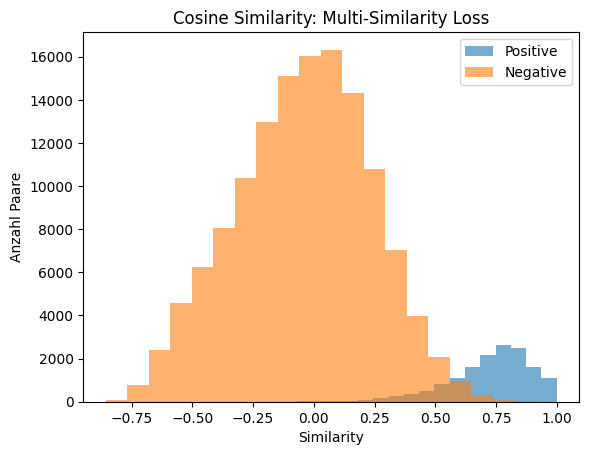

[Multi-Similarity Loss] ROC AUC: 0.9897


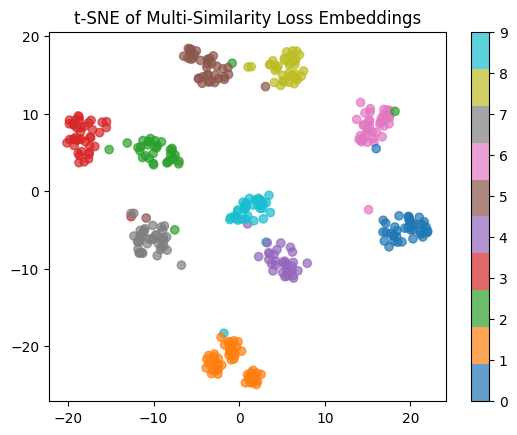

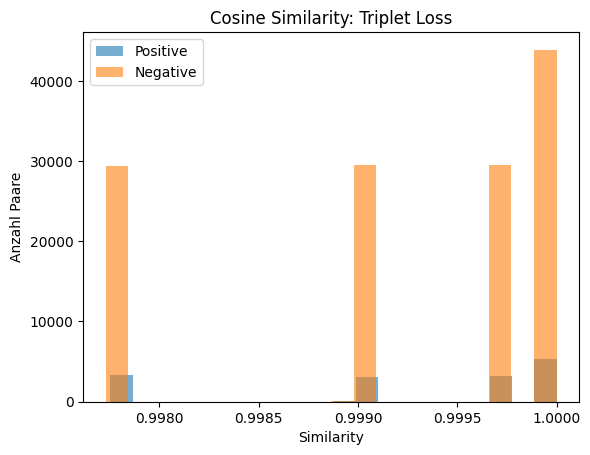

[Triplet Loss] ROC AUC: 0.5735


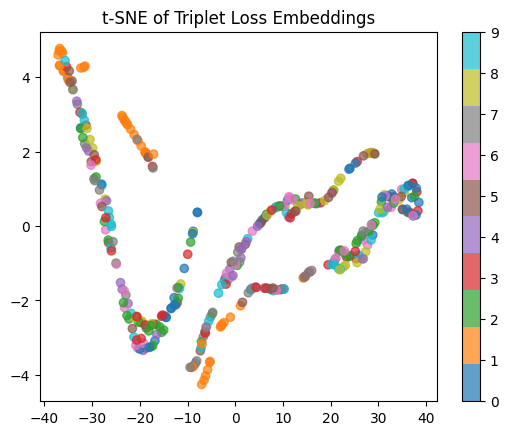

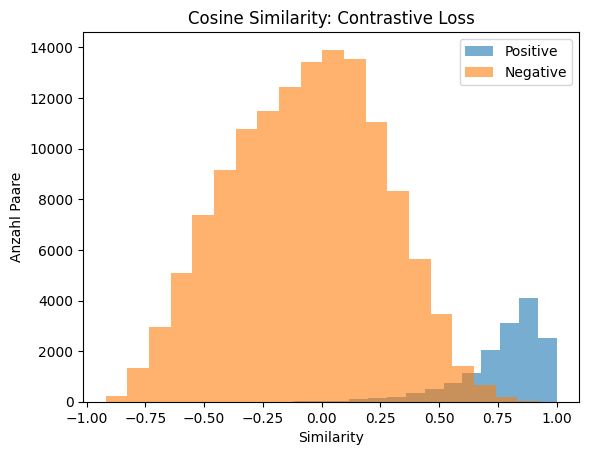

[Contrastive Loss] ROC AUC: 0.9864


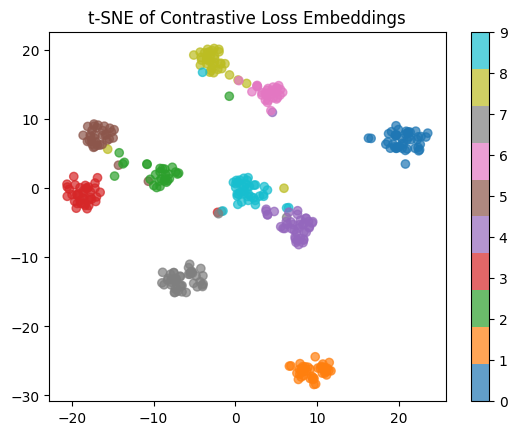

In [33]:
evaluate_embeddings(emb_ms, lab_ms, "Multi-Similarity Loss")
evaluate_embeddings(emb_triplet, lab_triplet, "Triplet Loss")
evaluate_embeddings(emb_contrastive, lab_contrastive, "Contrastive Loss")
